# Example scientific model
We demonstrate core features of DE-Sim with an implementation of a stochastic Susceptible, Infectious, or Recovered (SIR) epidemic model.

Stochastic modeling of epidemics is needed when the number of infectious individuals is small or when  variability in the rates of transitions between model states influences an epidemic's trajectory.
This example implements the well-known SIR (Susceptible-Infectious-Recovered) epidemic model.

[Describe the SIR model.]

This example models a discrete population of individuals each of whom is in one of three states:

* *Susceptible*: an individual who is could become infected if exposed
* *Infectious*: an individual who is infected, and could transmit the infection to a person who is susceptible
* *Recovered*: an individual who has recovered from an infection, and is not susceptible to being re-infected

The model below representes the transition of an individual between states as a single event.

First, use `pip` to install `de_sim`.

In [1]:
!pip install de_sim

     |████████████████████████████████| 48 kB 3.2 MB/s  eta 0:00:01
     |████████████████████████████████| 175 kB 26.9 MB/s eta 0:00:01
  Created wheel for pympler: filename=Pympler-0.8-py3-none-any.whl size=164713 sha256=c794803199e4502e31a236d7b449a8af47248880c81d4a65d39d4bd1c1cb152f
  Stored in directory: /root/.cache/pip/wheels/a0/a9/99/337816ce8e8acc5b1849abe49c8f637a9be9a5005f72318ecf
Successfully built pympler
ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/_

In [2]:
""" Example DE-Sim implementations of stochastic Susceptible, Infectious, or Recovered (SIR) epidemic models

:Author: Arthur Goldberg <Arthur.Goldberg@mssm.edu>
:Date: 2020-07-08
:Copyright: 2020, Karr Lab
:License: MIT
"""

import enum
import numpy

from de_sim.event import Event
from de_sim.simulation_engine import SimulationEngine
from de_sim.simulation_message import SimulationMessage
from de_sim.simulation_object import ApplicationSimulationObject


class StateTransition(SimulationMessage):
    "State transition"
    attributes = ['transition']


class RecordTrajectory(SimulationMessage):
    "Record trajectory"


class Transition(enum.Enum):
    """ Transition values
    """
    s_to_i = enum.auto()
    i_to_r = enum.auto()


MESSAGE_TYPES = [StateTransition, RecordTrajectory]


class SIR(ApplicationSimulationObject):
    """ Implement a Susceptible, Infectious, or Recovered (SIR) epidemic model

    This example uses DE-Sim to implement a continuous-time Markov chain (CTMC) SIR
    epidemic model, as described in section 3 of Allen (2017).

    Allen, L.J., 2017. A primer on stochastic epidemic models: Formulation, numerical
    simulation, and analysis. Infectious Disease Modelling, 2(2), pp.128-142.

    Attributes:
        s (:obj:`int`): number of susceptible subjects
        i (:obj:`int`): number of infectious subjects
        N (:obj:`int`): total number of susceptible subjects, a constant
        beta (:obj:`float`): SIR beta parameter
        gamma (:obj:`float`): SIR gamma parameter
        recording_period (:obj:`float`): time step for recording state
        random_state (:obj:`numpy.random.RandomState`): a random state
        history (:obj:`list`): list of recorded states
    """
    def __init__(self, name, s, i, N, beta, gamma, recording_period):
        """ Initialize a SIR instance

        Args:
            name (:obj:`str`): the instance's name
            s (:obj:`int`): initial number of susceptible subjects, s(0)
            i (:obj:`int`): initial number of infectious subjects, i(0)
            N (:obj:`int`): total number of susceptible subjects, a constant
            beta (:obj:`float`): SIR beta parameter
            gamma (:obj:`float`): SIR gamma parameter
            recording_period (:obj:`float`): time step for recording state
            random_state (:obj:`numpy.random.RandomState`): random state
            history (:obj:`list`): list of recorded states
        """
        self.s = s
        self.i = i
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.recording_period = recording_period
        self.random_state = numpy.random.RandomState()
        self.history = []
        super().__init__(name)

    def send_initial_events(self):
        """ Send the initial events, and record the initial state
        """
        self.schedule_next_event()
        self.record_trajectory(None)

    def schedule_next_event(self):
        """ Schedule the next SIR event
        """
        rates = {'s_to_i': self.beta * self.s * self.i / self.N,
                 'i_to_r': self.gamma * self.i}
        lambda_val = rates['s_to_i'] + rates['i_to_r']
        if lambda_val == 0:
            return

        tau = self.random_state.exponential(1.0/lambda_val)
        prob_s_to_i = rates['s_to_i'] / lambda_val
        if self.random_state.random_sample() < prob_s_to_i:
            self.send_event(tau, self, StateTransition(Transition.s_to_i))
        else:
            self.send_event(tau, self, StateTransition(Transition.i_to_r))

    def handle_state_transition(self, event):
        """ Handle an infectious state transition

        Args:
            event (:obj:`Event`): simulation event that contains the type of transition
        """
        transition = event.message.transition
        if transition is Transition.s_to_i:
            self.s -= 1
            self.i += 1
        elif transition is Transition.i_to_r:
            self.i -= 1
        self.schedule_next_event()

    def record_trajectory(self, event):
        """ Add another record to the SIR history

        Args:
            event (:obj:`Event`): simulation event; not used
        """
        self.history.append(dict(time=self.time,
                                 s=self.s,
                                 i=self.i))
        self.send_event(self.recording_period, self, RecordTrajectory())

    event_handlers = [(StateTransition, 'handle_state_transition'),
                      (RecordTrajectory, 'record_trajectory')]

    # register the message types sent
    messages_sent = MESSAGE_TYPES

We run a SIR model in the next cell.

In [13]:
import pandas

class RunSIR(object):

    @staticmethod
    def main(time_max, seed, **sir_args):

        # create a simulator
        simulator = SimulationEngine()

        # create a SIR instance
        sir = SIR(**sir_args)
        simulator.add_object(sir)

        # initialize simulation, which sends the SIR instance an initial event message
        simulator.initialize()

        # run the simulation
        event_num = simulator.simulate(time_max).num_events
        print("Executed {} events.\n".format(event_num))
        return sir

    @staticmethod
    def print_history(sir):
        header = ['time', 's', 'i', 'r']
        print('\t'.join(header))
        for state in sir.history:
            state_as_list = [state['time'], state['s'], state['i'],
                             sir.N - state['s'] - state['i']]
            state_as_list = [str(v) for v in state_as_list]
            print('\t'.join(state_as_list))

    @staticmethod
    def history_to_dataframe(sir):
        fields = ('s', 'i', 'r')
        hist = []
        index = []
        for state in sir.history:
            state_as_list = [state['s'], state['i'], sir.N - state['s'] - state['i']]
            hist.append(dict(zip(fields, state_as_list)))
            index.append(state['time'])
        return pandas.DataFrame(hist)

sir_args = dict(name='sir',
                s=98,
                i=2,
                N=100,
                beta=0.3,
                gamma=0.15,
                recording_period=10)
sir = RunSIR.main(100, 17, **sir_args)

Executed 182 events.



In [14]:
RunSIR.print_history(sir)

time	s	i	r
0	98	2	0
10	88	10	2
20	62	20	18
30	31	22	47
40	20	7	73
50	17	5	78
60	15	4	81
70	13	2	85
80	13	1	86
90	13	1	86
100	13	0	87


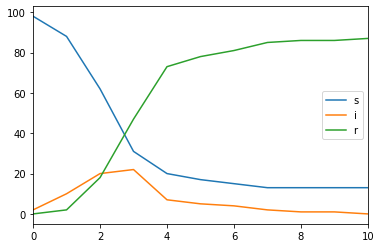

In [15]:
sir_data_frame = RunSIR.history_to_dataframe(sir)
sir_data_frame.plot()